In [1]:
#Data Handling
import pandas as pd
import numpy as np
import tifffile as tiff
from math import pi
import os

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Data Manipulation
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from scipy.signal import find_peaks

In [22]:
dict_of_mutants = {
    'jRGECO1a':['65','02','03','04'],
    'D111V': ['05','06','07','08'],
    'A318I': ['09','10','11','12'],
    'A318V': ['13','14','15','16'],
    'E357L': ['17','18','19','20'],
    'L415A': ['25','26','27','28'],
    'S319D': ['29','30','31','32'],
    'E357A': ['33','34','35','36'],
    'R393L': ['41','42','43','44'],
    'R393V': ['45','46','47','48'],
    'D111M': ['49','50','51','52'],
    'D111V_M375W': ['61','62','63','64']                
}

variant_color_map = {
    'jRGECO1a': '#08e2bb',
    'D111V': '#c0f8ef',
    'A318I': '#81cec2',
    'A318V': '#0c987D',
    'E357L': '#acc5f0',
    'L415A': '#69afed',
    'S319D': '#1664ee',
    'E357A': '#c1ffff',
    'R393L': '#65c1a3',
    'R393V': '#77abd9',
    'D111M': '#3fb2c4',
    'D111V_M375W': '#1e90c1'
}

path_1 = "C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/2024_12_23_jRGECO1a_Mutations/2024-12-26_CP_segementation_and_analysis/analysis/"
last_bit = '_delta_f_over_f_analysis.csv'
output_folder = "C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/2024_12_23_jRGECO1a_Mutations/2024-12-26_CP_segementation_and_analysis/results"
os.makedirs(output_folder, exist_ok=True)

In [3]:
list_of_mutants = []
delta_f_output_df = pd.DataFrame()

for label in dict_of_mutants:
  list_of_mutants.append(label)

for mutant in dict_of_mutants.keys():
    list_ = [] 
    for video_number in dict_of_mutants[mutant]:
        data = list(pd.read_csv(path_1+video_number+last_bit,index_col = 0)['max ∆F/F (%)'].values)
        
        # Calculate IQR
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1

        # Filter data within IQR
        inner_iqr_values = [x for x in data if q1 <= x <= q3]
        list_ = list_ + inner_iqr_values

    delta_f_output_df = pd.concat([delta_f_output_df,pd.DataFrame({'delta_f':list_, 'variant':[mutant for e in list_]})])

delta_f_output_df

,delta_f,variant
0,476.431264,jRGECO1a
1,470.776980,jRGECO1a
2,460.945675,jRGECO1a
3,459.050078,jRGECO1a
4,454.910024,jRGECO1a
...,...,...
186,128.599898,D111V_M375W
187,92.230164,D111V_M375W
188,90.318368,D111V_M375W
189,84.190439,D111V_M375W


In [5]:
means = []
std_devs = []
colors = []

variants = delta_f_output_df['variant'].unique()

for i, variant in enumerate(variants):
    data_points = delta_f_output_df[delta_f_output_df['variant'] == variant]['delta_f'].values
    mean = np.mean(data_points)
    std_dev = np.std(data_points)
    means.append(mean)
    std_devs.append(std_dev)
    colors.append(variant_color_map.get(variant, '#000000'))


sorted_indices = np.argsort(means)[::-1]
sorted_variants = [variants[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_std_devs = [std_devs[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

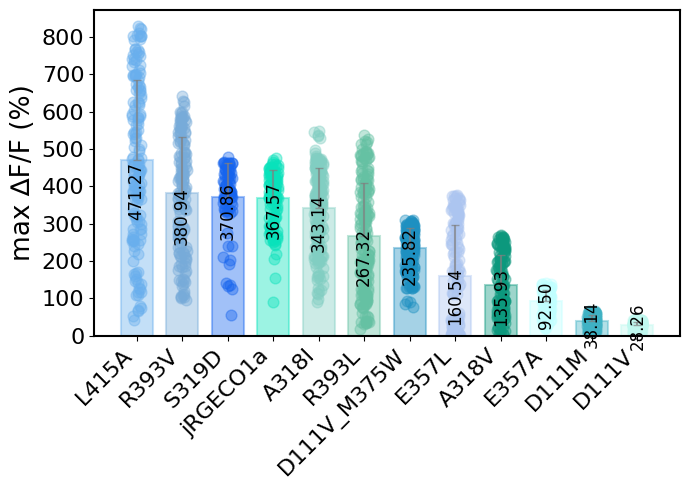

'C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/2024_12_23_jRGECO1a_Mutations/2024-12-26_CP_segementation_and_analysis/results\\max F-F (percent).pdf'

In [7]:
plt.figure(figsize=(7, 5))

for i, (variant, mean, std_dev, color) in enumerate(zip(sorted_variants, sorted_means, sorted_std_devs, sorted_colors)):
    data_points = delta_f_output_df[delta_f_output_df['variant'] == variant]['delta_f'].values
    x_positions = np.full_like(data_points, i, dtype=float) + (np.random.rand(len(data_points)) - 0.5) * 0.2
    
    # Scatter Plot
    plt.scatter(x_positions, data_points, color=color, label=variant, alpha=0.4, s=60)
    
    # Bar Plot
    plt.bar(i, mean, color=color, edgecolor=color, linewidth=1.5, alpha=0.4, width=0.7)
    
    # Mean Values
    plt.text(i, mean - std_dev * 0.4, f"{mean:.2f}", ha='center', va='center', fontsize=12, color='black', rotation=90)

    # Error Bars (only show positive standard deviation)
    upper_error = std_dev if std_dev > 0 else 0
    lower_error = 0

    if upper_error > 0:
        plt.errorbar(
            i, mean,
            yerr=[[lower_error], [upper_error]],
            fmt='', color='grey', alpha=0.7, capsize=3
        )

# X-Y axis
plt.ylabel("max ∆F/F (%)", fontsize=19)
plt.yticks(fontsize=16)
plt.xticks(
    ticks=np.arange(len(sorted_variants)),
    labels=sorted_variants,
    fontsize=16, rotation=45,
    ha='right', va='top'
)

# Outer box
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)


plt.tight_layout()
output_file = os.path.join(output_folder, "max F-F (percent).pdf")
plt.savefig(output_file, format='pdf')
plt.show()
output_file

In [23]:
list_of_mutants = []
baseline_output_df = pd.DataFrame()

for label in dict_of_mutants:
  list_of_mutants.append(label)

for mutant in dict_of_mutants.keys():
    list_ = [] 
    for video_number in dict_of_mutants[mutant]:
        data = list(pd.read_csv(path_1+video_number+last_bit,index_col = 0)['Baseline'].values)
        
        # Calculate IQR
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1

        # Filter data within IQR
        inner_iqr_values = [x for x in data if q1 <= x <= q3]
        list_ = list_ + inner_iqr_values

    baseline_output_df = pd.concat([baseline_output_df,pd.DataFrame({'Baseline':list_, 'variant':[mutant for e in list_]})])

baseline_output_df

,Baseline,variant
0,47.0530,jRGECO1a
1,36.0220,jRGECO1a
2,47.8035,jRGECO1a
3,67.4520,jRGECO1a
4,48.2995,jRGECO1a
...,...,...
186,394.2350,D111V_M375W
187,509.3635,D111V_M375W
188,593.3485,D111V_M375W
189,250.3935,D111V_M375W


In [24]:
means = []
std_devs = []
colors = []

variants = baseline_output_df['variant'].unique()

for i, variant in enumerate(variants):
    data_points = baseline_output_df[baseline_output_df['variant'] == variant]['Baseline'].values
    mean = np.mean(data_points)
    std_dev = np.std(data_points)
    means.append(mean)
    std_devs.append(std_dev)
    colors.append(variant_color_map.get(variant, '#000000'))


sorted_indices = np.argsort(means)[::-1]
sorted_variants = [variants[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_std_devs = [std_devs[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

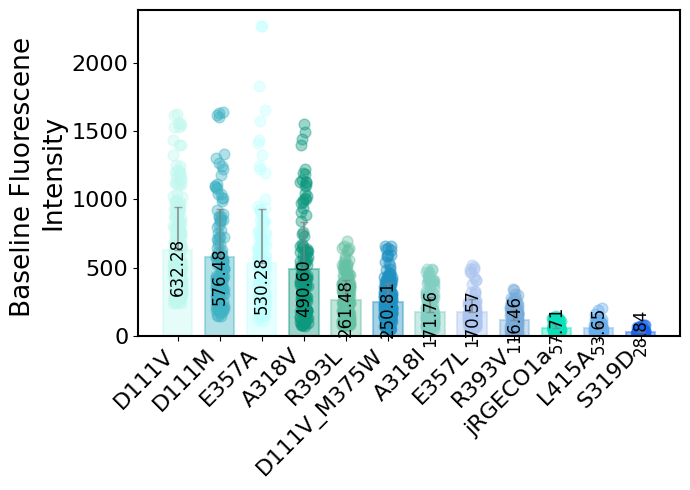

'C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/2024_12_23_jRGECO1a_Mutations/2024-12-26_CP_segementation_and_analysis/results\\Baseline_Fluorescene_Intensity.pdf'

In [25]:
plt.figure(figsize=(7, 5))

for i, (variant, mean, std_dev, color) in enumerate(zip(sorted_variants, sorted_means, sorted_std_devs, sorted_colors)):
    data_points = baseline_output_df[baseline_output_df['variant'] == variant]['Baseline'].values
    x_positions = np.full_like(data_points, i, dtype=float) + (np.random.rand(len(data_points)) - 0.5) * 0.2
    
    # Scatter Plot
    plt.scatter(x_positions, data_points, color=color, label=variant, alpha=0.4, s=60)
    
    # Bar Plot
    plt.bar(i, mean, color=color, edgecolor=color, linewidth=1.5, alpha=0.4, width=0.7)
    
    # Mean Values
    plt.text(i, mean - std_dev * 0.4, f"{mean:.2f}", ha='center', va='center', fontsize=12, color='black', rotation=90)

    # Error Bars (only show positive standard deviation)
    upper_error = std_dev if std_dev > 0 else 0
    lower_error = 0

    if upper_error > 0:
        plt.errorbar(
            i, mean,
            yerr=[[lower_error], [upper_error]],
            fmt='', color='grey', alpha=0.7, capsize=3
        )

# X-Y axis
plt.ylabel("Baseline Fluorescene \nIntensity", fontsize=19)
plt.yticks(fontsize=16)
plt.xticks(
    ticks=np.arange(len(sorted_variants)),
    labels=sorted_variants,
    fontsize=16, rotation=45,
    ha='right', va='top'
)

# Outer box
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)


plt.tight_layout()
output_file = os.path.join(output_folder, "Baseline_Fluorescene_Intensity.pdf")
plt.savefig(output_file, format='pdf')
plt.show()
output_file

In [26]:
last_bit = '_delta_f_over_f_raw.csv'
list_of_mutants = []
kinetic_df = pd.DataFrame()

for label in dict_of_mutants:
    list_of_mutants.append(label)

for mutant in dict_of_mutants.keys():
    mutant_info = []
    list_ = []
    
    for video_number in dict_of_mutants[mutant]:
        print(video_number)
        data = pd.read_csv(path_1 + video_number + last_bit, index_col=0)
        video_list = []
        
        for col in data.columns:
            if data[col].max() > 1:
                delta_list = []
                index = data[col].idxmax()
                index_pos = data.index.get_loc(index)
                
                if index_pos > 30 and index_pos < 80:
                    for I in range(10):
                        if (index_pos + I + 1) < len(data):
                            delta = abs((data[col].iloc[index_pos + I + 1]) / data[col].max() - (data[col].iloc[index_pos + I]) / data[col].max())
                            delta_list.append(delta)

                if len(delta_list) > 0:
                    video_list.append(sum(delta_list) * 100 / 5)
                    mutant_info.append(sum(delta_list) * 100 / 5)

        print(video_list)

        q1 = np.percentile(video_list, 25)
        q3 = np.percentile(video_list, 75)
        iqr = q3 - q1
        inner_iqr_values = [x for x in video_list if q1 <= x <= q3]
        list_ += inner_iqr_values

    kinetic_df = pd.concat([kinetic_df, pd.DataFrame({'kinetics': list_, 'variant': [mutant] * len(list_)})])

65
[np.float64(3.411725390783753), np.float64(0.9463695920213411), np.float64(5.533877686722876), np.float64(4.516224653329823), np.float64(5.3258874126592755), np.float64(4.2517149636806595), np.float64(5.33602073052166), np.float64(2.8777475727186164), np.float64(3.911294931625604), np.float64(4.122709262904116), np.float64(11.28637579485664), np.float64(4.913423821170076), np.float64(2.464250978480933), np.float64(2.411370938298929), np.float64(2.729860422584205), np.float64(2.048710912962608), np.float64(4.081523234361571), np.float64(6.086113132480524), np.float64(3.6441467394929683), np.float64(5.195530994365727), np.float64(3.801311015597919), np.float64(2.83044482051122), np.float64(7.044951764479623), np.float64(2.980967672307868), np.float64(3.2120405562292853), np.float64(2.825238350770203), np.float64(3.8171816346781595), np.float64(5.225363481915766), np.float64(2.6000141200360805), np.float64(2.8712383381833617), np.float64(2.3318502521231066), np.float64(4.18083176315504

In [27]:
means = []
std_devs = []
colors = []

variants = kinetic_df['variant'].unique()

for i, variant in enumerate(variants):
    data_points = kinetic_df[kinetic_df['variant'] == variant]['kinetics'].values
    mean = np.mean(data_points)
    std_dev = np.std(data_points)
    means.append(mean)
    std_devs.append(std_dev)
    colors.append(variant_color_map.get(variant, '#000000'))


sorted_indices = np.argsort(means)[::-1]
sorted_variants = [variants[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_std_devs = [std_devs[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

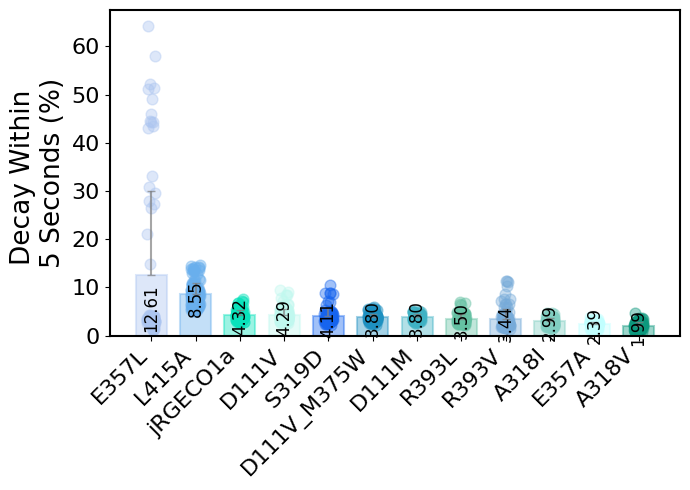

'C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/2024_12_23_jRGECO1a_Mutations/2024-12-26_CP_segementation_and_analysis/results\\Decay_Within_5_Seconds.pdf'

In [28]:
plt.figure(figsize=(7, 5))

for i, (variant, mean, std_dev, color) in enumerate(zip(sorted_variants, sorted_means, sorted_std_devs, sorted_colors)):
    data_points = kinetic_df[kinetic_df['variant'] == variant]['kinetics'].values
    x_positions = np.full_like(data_points, i, dtype=float) + (np.random.rand(len(data_points)) - 0.5) * 0.2
    
    # Scatter Plot
    plt.scatter(x_positions, data_points, color=color, label=variant, alpha=0.4, s=60)
    
    # Bar Plot
    plt.bar(i, mean, color=color, edgecolor=color, linewidth=1.5, alpha=0.4, width=0.7)
    
    # Mean Values
    plt.text(i, mean - std_dev * 0.4, f"{mean:.2f}", ha='center', va='center', fontsize=12, color='black', rotation=90)

    # Error Bars (only show positive standard deviation)
    upper_error = std_dev if std_dev > 0 else 0
    lower_error = 0

    if upper_error > 0:
        plt.errorbar(
            i, mean,
            yerr=[[lower_error], [upper_error]],
            fmt='', color='grey', alpha=0.7, capsize=3
        )

# X-Y axis
plt.ylabel("Decay Within \n5 Seconds (%)", fontsize=19)
plt.yticks(fontsize=16)
plt.xticks(
    ticks=np.arange(len(sorted_variants)),
    labels=sorted_variants,
    fontsize=16, rotation=45,
    ha='right', va='top'
)

# Outer box
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)


plt.tight_layout()
output_file = os.path.join(output_folder, "Decay_Within_5_Seconds.pdf")
plt.savefig(output_file, format='pdf')
plt.show()
output_file

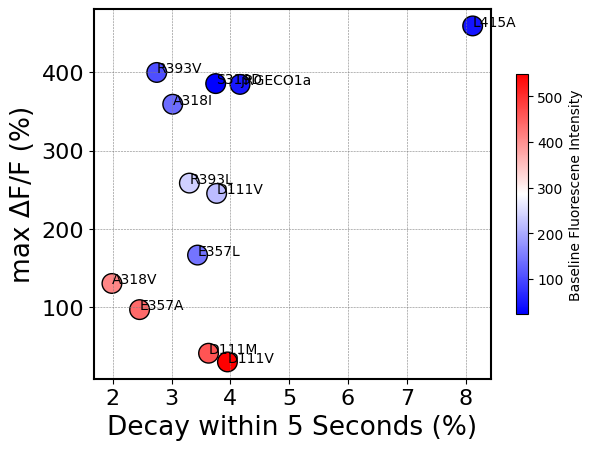

'C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/2024_12_23_jRGECO1a_Mutations/2024-12-26_CP_segementation_and_analysis/results\\Hotplot.pdf'

In [36]:
kinetic_output_list = []
delta_f_output_list = []
baseline_output_list = []
mutant_output_list = []

for variant in kinetic_df['variant'].unique():
    variant_kinetic = kinetic_df[kinetic_df['variant'] == variant]['kinetics']
    variant_delta_f = delta_f_output_df[delta_f_output_df['variant'] == variant]['delta_f']
    variant_baseline = baseline_output_df[baseline_output_df['variant'] == variant]['Baseline']
    
    u = np.median(variant_kinetic)  # x-position of the center
    v = np.median(variant_delta_f)  # y-position of the center
    z = np.median(variant_baseline)

    kinetic_output_list.append(u)
    delta_f_output_list.append(v)
    baseline_output_list.append(z)
    mutant_output_list.append(variant)

df = pd.DataFrame({'kinetics': kinetic_output_list,
                   'delta_f': delta_f_output_list,
                   'baseline': baseline_output_list,
                   'mutant': mutant_output_list})

variant = 'jRGECO1a'

variant_kinetic = kinetic_df[kinetic_df['variant'] == variant]['kinetics']
variant_delta_f = delta_f_output_df[delta_f_output_df['variant'] == variant]['delta_f']
variant_baseline = baseline_output_df[baseline_output_df['variant'] == variant]['Baseline']

u = np.median(variant_kinetic)  # x-position of the center
v = np.median(variant_delta_f)  # y-position of the center
z = np.median(variant_baseline)

plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.4, color='gray')

plt.scatter(df.kinetics, df.delta_f, s=200, c=df.baseline, cmap='bwr', edgecolors='black')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Decay within 5 Seconds (%)', fontsize=19)
plt.ylabel('max ΔF/F (%)', fontsize=19)
plt.colorbar(label='Baseline Fluorescene Intensity', shrink=0.65)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

for row in range(len(df)):
    plt.text(x=df.iloc[row]['kinetics'], y=df.iloc[row]['delta_f'], s=str.split(df.iloc[row]['mutant'], '_')[0])

output_file = os.path.join(output_folder, "Hotplot.pdf")
plt.savefig(output_file, format='pdf')
plt.show()
output_file

In [30]:
base_path = r"C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/2024_12_23_jRGECO1a_Mutations/"

variants = {
    "L415A": [
        (os.path.join(base_path, "BS50/sample_25.tif"), os.path.join(base_path, "2024-12-26_CP_segementation_and_analysis/mask/25_mask.npy")),
        (os.path.join(base_path, "BS50/sample_26.tif"), os.path.join(base_path, "2024-12-26_CP_segementation_and_analysis/mask/26_mask.npy")),
        (os.path.join(base_path, "BS50/sample_27.tif"), os.path.join(base_path, "2024-12-26_CP_segementation_and_analysis/mask/27_mask.npy")),
        (os.path.join(base_path, "BS50/sample_28.tif"), os.path.join(base_path, "2024-12-26_CP_segementation_and_analysis/mask/28_mask.npy"))
    ],
    "jRGECO1a": [
        (os.path.join(base_path, "BS50/sample_65.tif"), os.path.join(base_path, "2024-12-26_CP_segementation_and_analysis/mask/65_mask.npy")),
        #(os.path.join(base_path, "BS50/sample_02.tif"), os.path.join(base_path, "2024-12-26_CP_segementation_and_analysis/mask/02_mask.npy")),
        (os.path.join(base_path, "BS50/sample_03.tif"), os.path.join(base_path, "2024-12-26_CP_segementation_and_analysis/mask/03_mask.npy")),
        (os.path.join(base_path, "BS50/sample_04.tif"), os.path.join(base_path, "2024-12-26_CP_segementation_and_analysis/mask/04_mask.npy"))
    ]
}


In [31]:
results = {}

for variant, files in variants.items():
    all_dff = []
    for tif_file, mask_file in files:
        if not os.path.exists(tif_file) or not os.path.exists(mask_file):
            print(f"File missing for {variant}: {tif_file} or {mask_file}")
            continue

        tif_data = tiff.imread(tif_file)
        mask = np.load(mask_file)

        assert tif_data.ndim == 3
        frames, height, width = tif_data.shape
        roi_ids = np.unique(mask[mask > 0])

        mean_intensities = []
        for frame_idx in range(frames):
            frame = tif_data[frame_idx]
            roi_means = [frame[mask == roi_id].mean() for roi_id in roi_ids]
            mean_intensities.append(np.mean(roi_means))

        mean_intensities = np.array(mean_intensities)

        # Calculate the first 20 frames fluorescene intensity as baseline
        f0 = mean_intensities[:20].mean()
        dff = (mean_intensities - f0) / f0
        all_dff.append(dff)

    all_dff = np.array(all_dff)
    mean_dff = all_dff.mean(axis=0)
    sem_dff = all_dff.std(axis=0) / np.sqrt(all_dff.shape[0])

    results[variant] = {
        "mean_dff": mean_dff,
        "sem_dff": sem_dff,
    }

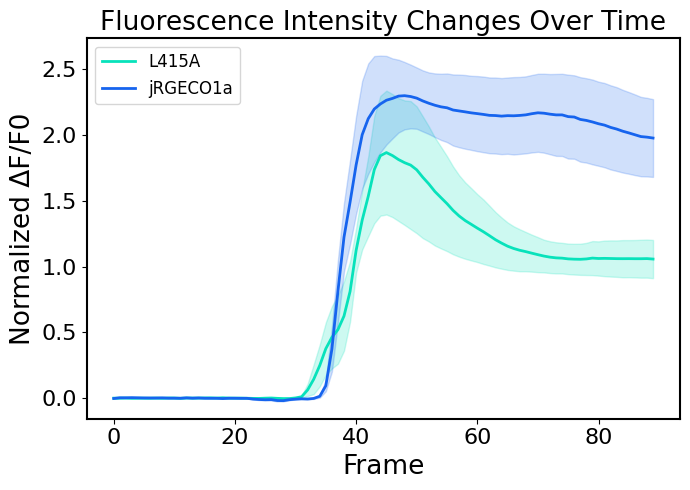

'C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/2024_12_23_jRGECO1a_Mutations/2024-12-26_CP_segementation_and_analysis/results\\Normalized_F-F0.pdf'

In [33]:
plt.figure(figsize=(7, 5))

colors = ["#08e2bb", "#1664ee"]
for i, (variant, data) in enumerate(results.items()):
    mean_dff = data["mean_dff"]
    sem_dff = data["sem_dff"]

    plt.fill_between(
        range(len(mean_dff)), 
        mean_dff - sem_dff, 
        mean_dff + sem_dff, 
        color=colors[i], alpha=0.2
    )

    plt.plot(mean_dff, color=colors[i], label=f"{variant}", linewidth=2)


plt.tick_params(axis='both', labelsize=16)
plt.xlabel("Frame", fontsize=19)
plt.ylabel("Normalized ΔF/F0", fontsize=19)
plt.title("Fluorescence Intensity Changes Over Time", fontsize=19)
plt.legend(fontsize=12)
plt.tight_layout()

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)


output_file = os.path.join(output_folder, "Normalized_F-F0.pdf")
plt.savefig(output_file, format='pdf')
plt.show()
output_file